In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nameisalfio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Loading dataset

In [2]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.sample(50)

,id,keyword,location,text,target
5393,7694,panic,Torry Alvarez love forever ? ?,Panic at the disco te amo,0
4614,6559,injury,"Shah Alam,Malaysia",Had a nightmare and was about to jump out of b...,0
7463,10679,wounds,Not Steven Yeun / AMC.,@DauntedPsyche - Man gently dabbed the cotton ...,0
1750,2517,collision,"Denver, CO",Motorcyclist bicyclist injured in Denver colli...,1
6419,9179,suicide%20bomber,NaN,Suicide bomber kills 15 in Saudi security site...,1
5384,7683,panic,East TN.,@biggangVH1 looks like George was having a pan...,0
2885,4146,drought,"Los Angeles, CA",'It's an eerie way of revealing both our histo...,0
1908,2743,crushed,NaN,So many Youtube commenters saying the Dothraki...,1
3905,5555,flattened,Pomfret/Providence,'the fallacy is it is up to the steam roller. ...,0
4524,6429,hurricane,NaN,@Hurricane_Dolce no prob,1


# 3. Data exploration

target
0    4342
1    3271
Name: count, dtype: int64


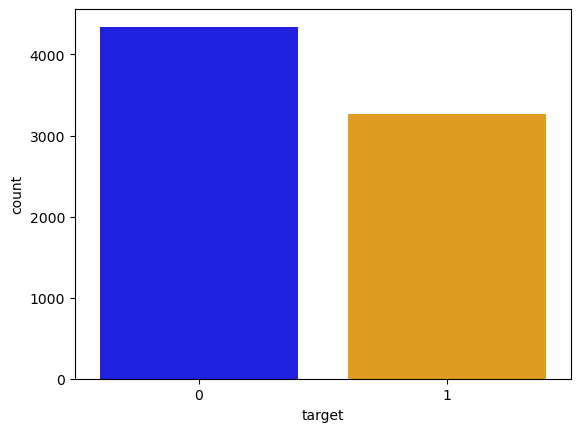

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

x = train['target'].value_counts()
print(x)

# Specifica manualmente i colori per ciascuna barra
colors = ['blue', 'orange']

sns.barplot(x=x.index, y=x, hue=x.index, palette=colors, legend=False)
plt.show()

In [25]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
color          0
dtype: int64

## 3.2 Number of words and characters

In [29]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
print(train[train['target']==1]['word_count'].mean()) #Disaster tweets
print(train[train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


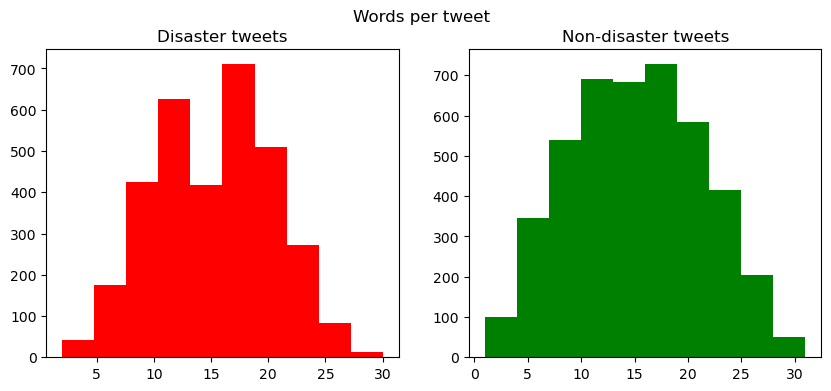

In [31]:
from matplotlib import pyplot as plt

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [33]:
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
print(train[train['target']==1]['char_count'].mean()) #Disaster tweets
print(train[train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


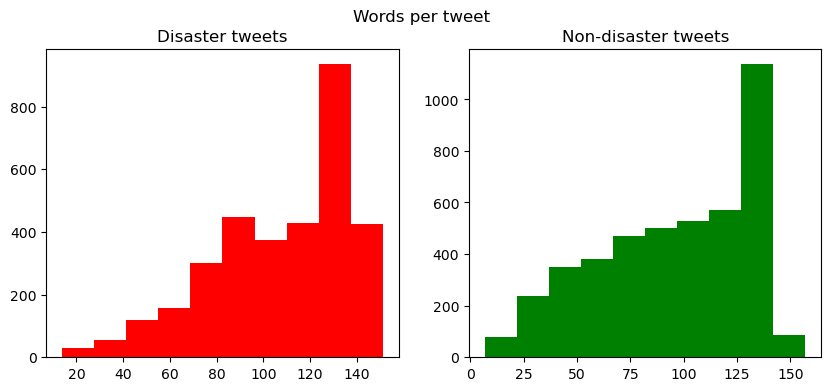

In [35]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['char_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['char_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

# 4 Text pre-processing

we will apply the following operations:

- Lowercasing
- Entities, URL Links and Punctuation Removal
- Spelling Correction
- Lemmatization
- Stop Words Removal

## 4.1 Lowercasing

In [37]:
train["keyword"] = train["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["clean_text"] = train["text"].apply(lambda x: str.lower(x))
train.sample(5)

,id,keyword,location,text,target,color,word_count,char_count,clean_text
4282,6085,hellfire,rheinbach / germany,Orchid - Sign Of The Witch http://t.co/YtkXwPyIHg,0,blue,7,49,orchid - sign of the witch http://t.co/ytkxwpyihg
781,1130,blight,kama | 18 | france,@DaMidnighter theres actually a theory out the...,0,blue,23,136,@damidnighter theres actually a theory out the...
1718,2479,collided,NaN,My @MLG and food worlds have collided in this ...,0,blue,16,130,my @mlg and food worlds have collided in this ...
1688,2437,collide,"new orleans, la",#NowPlaying the playlist 'When Jazz and Hip-Ho...,0,blue,11,93,#nowplaying the playlist 'when jazz and hip-ho...
6588,9434,survivors,upstairs.,People with netflix there's a really good docu...,0,blue,21,137,people with netflix there's a really good docu...
